# Assignment 3: Colors and Word Models.

The following cells describe how to build a neural network that generates color names from RGB values.

We can give the neural network a list of paint colors (14157) along with their RGB values. (RGB = red, green, and blue color values).

Could the neural network learn to invent new paint colors and give them "meaningful" names?

In [168]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


import numpy as np
import pandas as pd

np.random.seed(10)
print (tf.__version__)

2.3.1


In [169]:
import io
import requests
url="https://raw.githubusercontent.com/Tony607/Keras-Colors/master/colors.csv"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head(20)

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130
5,light urple,179,111,246
6,east side,172,145,206
7,florida seashells,250,228,199
8,paris,145,167,189
9,powder blush,247,215,215


In [170]:
len(data)

14157

In [171]:
names = data["name"]

## Tokenize, char level

We will consider that every color name is a sequences of characters (max=25).

In [172]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

In [173]:
padded_names[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       15,  2,  3,  2, 21,  1,  1,  9], dtype=int32)

## One-hot encoding

We use a one-hot estrategy to encode characters.

In [174]:
from keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)
num_classes = one_hot_names.shape[-1]
num_classes

28

In [175]:
one_hot_names.shape

(14157, 25, 28)

In [176]:
t.word_index

{'e': 1,
 'a': 2,
 'r': 3,
 ' ': 4,
 'i': 5,
 'n': 6,
 'l': 7,
 'o': 8,
 't': 9,
 's': 10,
 'c': 11,
 'u': 12,
 'd': 13,
 'g': 14,
 'p': 15,
 'h': 16,
 'm': 17,
 'b': 18,
 'y': 19,
 'w': 20,
 'k': 21,
 'f': 22,
 'v': 23,
 'z': 24,
 'q': 25,
 'j': 26,
 'x': 27}

In [177]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])


Now we build a LSTM model that reads sequences of characters and produces a scaled-RGB triplet as output. This is a many-to-one sequential model. 

In [178]:
def LSTM_model(maxlen, num_classes):    
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
    model.add(LSTM(128))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

model = LSTM_model(25, 28)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25, 256)           291840    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 505,859
Trainable params: 505,859
Non-trainable params: 0
_________________________________________________________________


We train the model with our dataset.

In [ ]:
history = model.fit(one_hot_names, normalized_values,
                    epochs=40,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/40
399/399 [==============================] - 95s 237ms/step - loss: 0.0604 - acc: 0.6248 - val_loss: 0.0604 - val_acc: 0.6645
Epoch 2/40
399/399 [==============================] - 98s 246ms/step - loss: 0.0556 - acc: 0.6648 - val_loss: 0.0560 - val_acc: 0.6589
Epoch 3/40
399/399 [==============================] - 94s 235ms/step - loss: 0.0530 - acc: 0.6680 - val_loss: 0.0550 - val_acc: 0.6808
Epoch 4/40
399/399 [==============================] - 94s 235ms/step - loss: 0.0505 - acc: 0.6661 - val_loss: 0.0530 - val_acc: 0.6879
Epoch 5/40
399/399 [==============================] - 94s 234ms/step - loss: 0.0481 - acc: 0.6698 - val_loss: 0.0505 - val_acc: 0.6850
Epoch 6/40
399/399 [==============================] - 93s 234ms/step - loss: 0.0462 - acc: 0.6697 - val_loss: 0.0485 - val_acc: 0.6462
Epoch 7/40
399/399 [==============================] - 95s 238ms/step - loss: 0.0436 - acc: 0.6748 - val_loss: 0.0468 - val_acc: 0.6822
Epoch 8/40
399/399 [==============================] - 1

In [179]:
import matplotlib.pyplot as plt

def hist_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


Now we are ready to predict color of a random name:

In [180]:
# Plot a color image.
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [181]:
def scale(n):
    return int(n * 255) 

In [112]:
def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=num_classes)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

light blue, R,G,B: 156 214 243


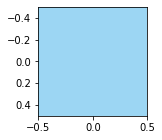

blue, R,G,B: 8 38 213


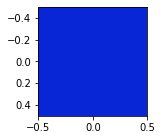

dark blue, R,G,B: 10 17 117


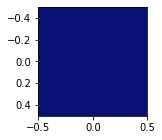

In [ ]:
predict("light blue")
predict("blue")
predict("dark blue")

black, R,G,B: 28 26 39


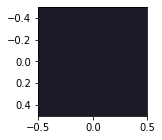

white, R,G,B: 244 241 238


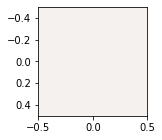

In [ ]:
predict("black")
predict("white")

tensorflow orange, R,G,B: 236 130 63


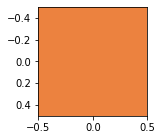

forest, R,G,B: 33 73 43


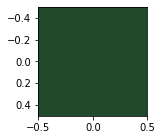

evergreen, R,G,B: 23 64 39


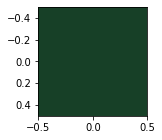

tangerine, R,G,B: 250 106 21


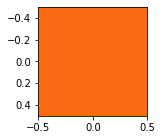

In [ ]:
predict("tensorflow orange")
predict("forest")
predict("evergreen")
predict("tangerine")

princess ivory, R,G,B: 219 220 194


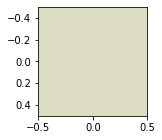

In [ ]:
predict("princess ivory")

bull cream, R,G,B: 231 236 205


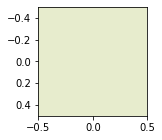

In [ ]:
predict("bull cream")

keras red, R,G,B: 192 31 49


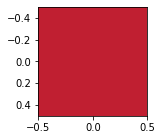

In [ ]:
predict("keras red")

tensorflow orange, R,G,B: 236 130 63


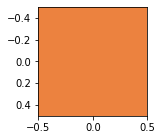

forest, R,G,B: 33 73 43


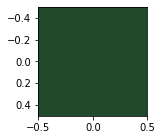

bull cream, R,G,B: 231 236 205


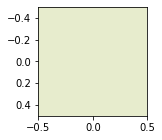

keras red, R,G,B: 192 31 49


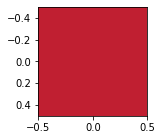

In [ ]:
predict("tensorflow orange")
predict("forest")
predict("bull cream")
predict("keras red")

## Questions and Exercises

1. We got, with the current model, a `val_acc = 0.6942` when training the model. Explore different strategies to train the model in order to get better results. Some ideas (no guarantee!):
    + You can train the model using character bigrams (such as `aa`, `ab`, ..., `zz`), or even trigrams, instead of characters. This should produce a more powerful model, but the devil is in the details. For example, some bigrams cannot be present in the training set but they might be in the training set. If we want to build a generic model we should consider any possible bigram.
    + You can use an embedding layer to represents bigrams or trigrams.
    + You can use bidirectional LSTM to learn sequences.
    + Etc.

2. Design and train a model to predict words from color. That is, your input will be a RGB triplet and your outputs a string. This is a one-to-many sequence model. This problem is harder than the previous one...

# Report

Please, answer the following questions (and include in this notebook all code necessary to suport your answers):

1. Which is the best model you have build? (architecture, word representations, etc.)
2. Report, in terms of accuracy, the best model you got to predict words from colors. Show examples. 


## <font color='red'> MY SOLUTIONS

Following the hints we will start with a bigram strategy. 

In order to do that we will consider all the possible bigrams (considering only letters and single blank space as possible characters). The tokens will be generated mapping on a dictonary with all the combinations and a fixed lenght $maxlen = 30$.

In [182]:
from sklearn.feature_extraction.text import CountVectorizer
import string
import itertools
import json

def dictionary_n(n):
    alpha = string.ascii_lowercase ; alpha = alpha + ' '
    all_n = [p for p in itertools.product(alpha, repeat=n)]
    all_n = [''.join(x) for x in all_n]
    for k in all_n:
        if "  " in k:
            all_n.remove(k)
    all_n = {k: v for v, k in enumerate(all_n)}
    return all_n

def tokens_ngram_generator(n, names,  maxlen):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), vocabulary=dictionary_n(n))
    X = vectorizer.fit_transform(names)
    X = np.array([x.indices for x in X])
    padded_X = tf.keras.preprocessing.sequence.pad_sequences(
               X, padding="pre", maxlen=maxlen)
    return padded_X

#To save history and model
def hist_model_save(mod, hist):
    model.save(str(mod)+'.h5')
    with open(str(hist)+'.json', 'w') as file:
        json.dump(hist.history, file)

#To compare two different validation accuracy plot        
def acc_comparison(hist1, hist2, lab1, lab2):    
    acc1 = hist1['val_acc']
    acc2 = hist2['val_acc']

    epochs1 = range(len(acc1))
    epochs2 = range(len(acc2))

    plt.plot(epochs1, acc1, 'r', label=lab1)
    plt.plot(epochs2, acc2, 'b', label=lab2)
    plt.title('Validation accuracy')
    plt.legend()

    plt.legend()

    plt.show()        

In [183]:
print('The number of classes for the bigram case is {}.'.format(len(dictionary_n(2))))

The number of classes for the bigram case is 728.


In [184]:
corpus = list(names.values)
padded_tok = tokens_ngram_generator(2, corpus, 30)
padded_tok.shape

(14157, 30)

As for the monogram case I performed a one hot encode. Obtaing for each color name a tensor of dimensions $30 \times 728$

In [185]:
one_hot_names = np_utils.to_categorical(padded_tok)
num_classes_bi = one_hot_names.shape[-1]
num_classes_bi, one_hot_names.shape

(728, (14157, 30, 728))

After some trial, I decided to add some dropout layers in order to fight overfitting.

In [19]:
def LSTM_model_DO(maxlen, num_classes):    
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
    model.add(Dropout(0.4))
    model.add(LSTM(128))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [20]:
model_bi = LSTM_model_DO(28, 728)
model_bi.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 28, 256)           1008640   
_________________________________________________________________
dropout (Dropout)            (None, 28, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [ ]:
model_bi = LSTM_model(28, 728)

checkpoint = ModelCheckpoint("model_bi_params.h5", monitor = "val_loss", verbose = 1, save_best_only = True)
model_bi.fit(one_hot_names, normalized_values, epochs = 40, validation_split = 0.1, callbacks = [checkpoint])

model_bi.load_weights("model_bi_params.h5")

In [117]:
import matplotlib.pyplot as plt

#To plot histories
def hist_plot(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Update prediction function to n-gram case


In [186]:
def predict_col(name, maxlen, num_classes, n, model):
    name = [name]
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), vocabulary=dictionary_n(n))
    x = vectorizer.fit_transform(name)
    x = np.array([x.indices])
    padded_x = tf.keras.preprocessing.sequence.pad_sequences(
               x, padding="pre", maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded_x, num_classes=num_classes)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name[0] + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

In [187]:
model_bi = load_model('model_bi_DO.h5')
model_bi.load_weights("model_bi_DO_params.h5")

As we can see, using a bigram, I improved a little bit the accuracy...

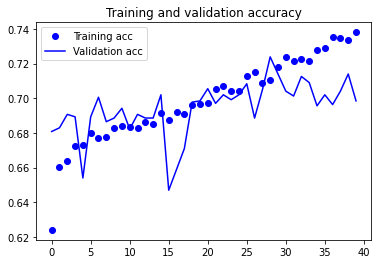

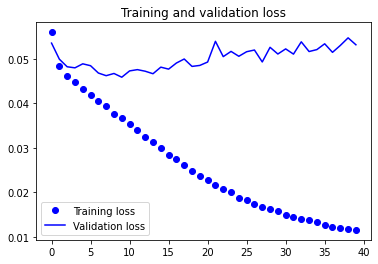

In [191]:
hist_bi = open('hist_bi_DO.json').read()
hist_bi = eval(hist_bi)
hist_plot(hist_bi)

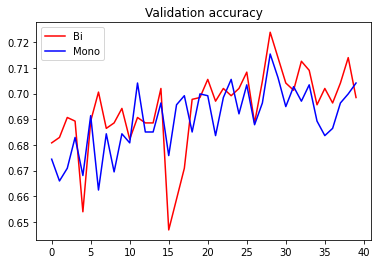

In [192]:
hist0 = open('history0.json').read()
hist0 = eval(hist0)
acc_comparison(hist_bi, hist0, 'Bi', 'Mono')

...but the number of dimensions (the time of computation) rise a lot. Again following the hints I try to add an embedding layer. After some trial and error i set an embedding dimension of 100. 

In [26]:
def LSTM_model_emb(num_classes, emb_dim):    
    from tensorflow.keras import layers
    # Input for variable-length sequences of integers
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a 100-dimensional vector
    x = layers.Embedding(num_classes, emb_dim)(inputs)
    # Add 2 LSTMs
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.LSTM(128)(x)
    x = layers.Dense(128)(x)
    # Add a classifier
    outputs = layers.Dense(3, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [27]:
model_emb = LSTM_model_emb(728, 100)
model_emb.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         72800     
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 256)         365568    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 652,387
Trainable params: 652,387
Non-trainable params: 0
________________________________________________

In [63]:
checkpoint = ModelCheckpoint("model_emb_params.h5", monitor = "val_loss", verbose = 1, save_best_only = True)

hist_emb = model_emb.fit(padded_tok, normalized_values, epochs = 40, validation_split = 0.1, callbacks = [checkpoint])

model_emb.load_weights("model_emb_params.h5")

Epoch 1/40
399/399 [==============================] - ETA: 0s - loss: 0.0484 - acc: 0.6645
Epoch 00001: val_loss improved from inf to 0.05094, saving model to model_emb_params.h5
399/399 [==============================] - 41s 102ms/step - loss: 0.0484 - acc: 0.6645 - val_loss: 0.0509 - val_acc: 0.6871
Epoch 2/40
399/399 [==============================] - ETA: 0s - loss: 0.0465 - acc: 0.6674
Epoch 00002: val_loss improved from 0.05094 to 0.05000, saving model to model_emb_params.h5
399/399 [==============================] - 45s 113ms/step - loss: 0.0465 - acc: 0.6674 - val_loss: 0.0500 - val_acc: 0.6928
Epoch 3/40
399/399 [==============================] - ETA: 0s - loss: 0.0450 - acc: 0.6698
Epoch 00003: val_loss improved from 0.05000 to 0.04861, saving model to model_emb_params.h5
399/399 [==============================] - 41s 103ms/step - loss: 0.0450 - acc: 0.6698 - val_loss: 0.0486 - val_acc: 0.6582
Epoch 4/40
399/399 [==============================] - ETA: 0s - loss: 0.0435 - acc:

Epoch 31/40
399/399 [==============================] - ETA: 0s - loss: 0.0060 - acc: 0.8298
Epoch 00031: val_loss did not improve from 0.04574
399/399 [==============================] - 39s 98ms/step - loss: 0.0060 - acc: 0.8298 - val_loss: 0.0539 - val_acc: 0.6773
Epoch 32/40
399/399 [==============================] - ETA: 0s - loss: 0.0058 - acc: 0.8280
Epoch 00032: val_loss did not improve from 0.04574
399/399 [==============================] - 42s 104ms/step - loss: 0.0058 - acc: 0.8280 - val_loss: 0.0525 - val_acc: 0.6773
Epoch 33/40
399/399 [==============================] - ETA: 0s - loss: 0.0056 - acc: 0.8335
Epoch 00033: val_loss did not improve from 0.04574
399/399 [==============================] - 36s 91ms/step - loss: 0.0056 - acc: 0.8335 - val_loss: 0.0525 - val_acc: 0.6949
Epoch 34/40
399/399 [==============================] - ETA: 0s - loss: 0.0054 - acc: 0.8378
Epoch 00034: val_loss did not improve from 0.04574
399/399 [==============================] - 36s 91ms/step -

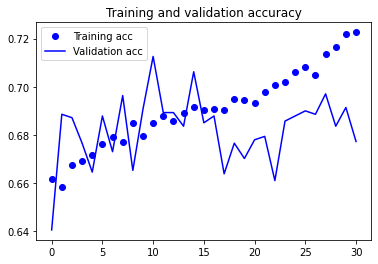

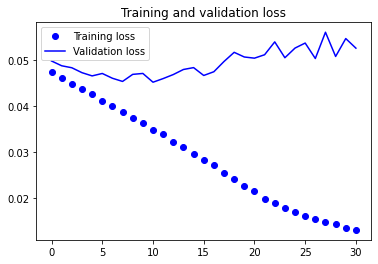

In [193]:
hist_emb = open('hist_emb.json').read()
hist_emb = eval(hist_emb)
hist_plot(hist_emb)

As we can see the improvement in accuracy is not that big. But we reduced a lot the dimensions, speeding up a lot the algorithm.

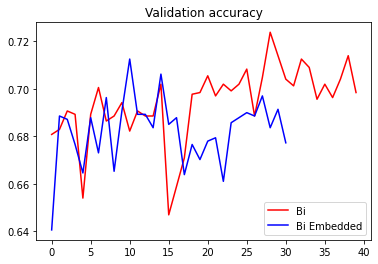

In [194]:
acc_comparison(hist_bi, hist_emb, 'Bi', 'Bi Embedded')

Updating the predict fuction for embedding models

In [188]:
# Plot a color image.
def plot_rgb_emb(rgb):
    data = [rgb]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def predict_n_emb(n, name, num_classes, maxlen, model):
    padded = tokens_ngram_generator(n, [name],  maxlen)
    pred = model.predict(padded.reshape(1,maxlen))
    r, g, b = pred[0][0], pred[0][1], pred[0][2]
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb_emb(pred)  

In [189]:
model_emb = load_model('model_emb.h5')
model_emb.load_weights("model_emb_params.h5")

blue, R,G,B: 0.2775743 0.40416342 0.61653286


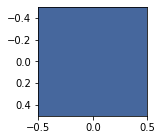

dark blue, R,G,B: 0.08565107 0.18510392 0.4893228


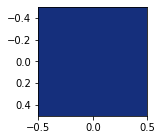

light blue, R,G,B: 0.5244903 0.6592218 0.8314103


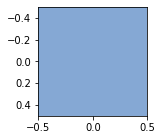

In [78]:
predict_n_emb(2, 'blue', 728, 30, model_emb)
predict_n_emb(2, 'dark blue', 728, 30, model_emb)
predict_n_emb(2, 'light blue', 728, 30, model_emb)

sky, R,G,B: 0.73684347 0.7606193 0.71285933


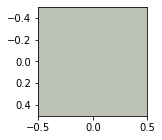

In [240]:
predict_n_emb(2, 'sky', 728, 30, model_emb)

Thanks to the embedding layer I tried a bigger dimensionality with a trigram word decomposition. Again I set the maxlen to 30. The number of classes rises to 19618.

In [190]:
corpus = list(names.values)
padded_tok3 = tokens_ngram_generator(3, corpus, 30)

padded_tok3.shape

(14157, 30)

In [191]:
maxlen = 30
one_hot_names = np_utils.to_categorical(padded_tok3)
num_classes_tri = one_hot_names.shape[-1]
num_classes_tri

19618

In [ ]:
checkpoint = ModelCheckpoint("model_emb3_params.h5", monitor = "val_loss", verbose = 1, save_best_only = True)
early_stop = EarlyStopping(patience=20)

hist_emb3 = model_emb3.fit(padded_tok_tri, normalized_values, epochs = 100, validation_split = 0.1, callbacks = [checkpoint, early_stop])



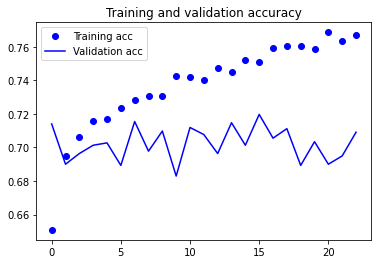

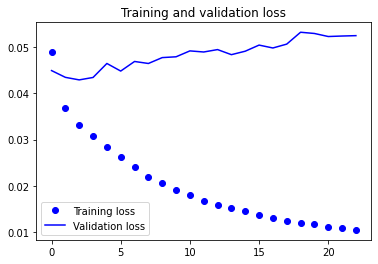

In [197]:
hist_emb3 = open('hist_emb_3.json').read()
hist_emb3 = eval(hist_emb3)
hist_plot(hist_emb3)

We improved a litlle bit more the accuracy.

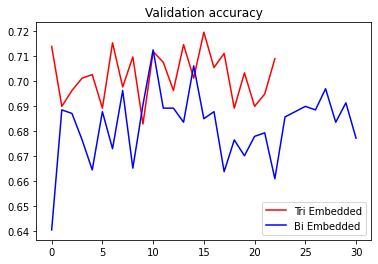

In [198]:
acc_comparison(hist_emb3, hist_emb, 'Tri Embedded', 'Bi Embedded')

In [192]:
model_emb3 = load_model('model_emb_3.h5')
model_emb3.load_weights("model_emb3_params.h5")

blue, R,G,B: 0.42242476 0.52171534 0.61463475


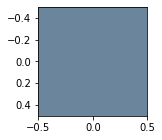

dark blue, R,G,B: 0.11906502 0.21899593 0.3936016


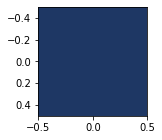

light blue, R,G,B: 0.5010363 0.6775973 0.75584924


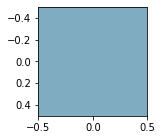

In [193]:
predict_n_emb(3, 'blue', 19618, 30, model_emb3)
predict_n_emb(3, 'dark blue', 19618, 30, model_emb3)
predict_n_emb(3, 'light blue', 19618, 30, model_emb3)

purple, R,G,B: 0.49583295 0.3566324 0.5678935


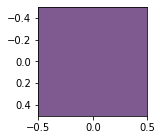

water melon, R,G,B: 0.835485 0.7168216 0.6826312


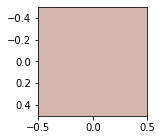

tear, R,G,B: 0.5768361 0.6765267 0.6199314


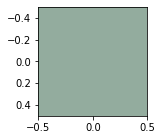

In [42]:
predict_n_emb(3, 'purple', 19618, 30, model_emb3)
predict_n_emb(3, 'water melon', 19618, 30, model_emb3)
predict_n_emb(3, 'tear', 19618, 30, model_emb3)

pablo, R,G,B: 0.6521207 0.41608447 0.42412025


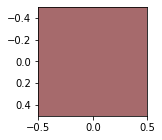

In [199]:
predict_n_emb(3, 'pablo', 19618, 30, model_emb3)


I try to improve the model accuracy adding bidirectional layers to the last model.

In [36]:
def LSTM_model_emb_bidir(num_classes, emb_dim):    
    from tensorflow.keras import layers
    # Input for variable-length sequences of integers
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a 100-dimensional vector
    x = layers.Embedding(num_classes, emb_dim)(inputs)
    # Add 2 LSTMs
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.3)(x)
    # Add a classifier
    outputs = layers.Dense(3, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [41]:
model_emb_tri_bidir = LSTM_model_emb_bidir(num_classes_tri, 100)
model_emb_tri_bidir.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         1961800   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         731136    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         656384    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)              

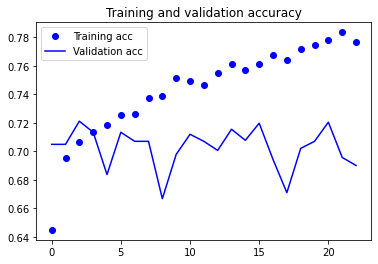

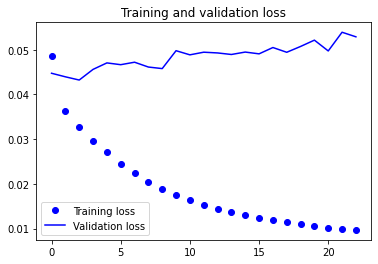

In [201]:
hist_emb3_bidir = open('hist_emb_tri_bidir.json').read()
hist_emb3_bidir = eval(hist_emb3_bidir)
hist_plot(hist_emb3_bidir)

But, as we can see, it seems that it does'nt change a lot. Overfitting is till very big...

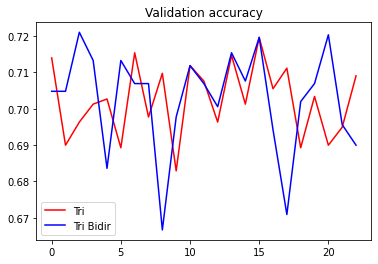

In [202]:
acc_comparison(hist_emb3, hist_emb3_bidir, 'Tri', 'Tri Bidir')

...and so i try to augment data, simply looking for bigger and different dataset in the web.

In [200]:
data_2 = pd.read_csv('colornames.csv')
data_2.head()

,name,hex
0,100 Mph,#c93f38
1,18th Century Green,#a59344
2,1975 Earth Red,#7b463b
3,1989 Miami Hotline,#dd3366
4,20000 Leagues Under the Sea,#191970


Here some function to preprocess the data

In [201]:
#dropping number
def thereisnumber(text):
    import re
    if re.findall(r"\d", text):
        return False
    else:
        return True 

#preprocessing
def preproc(df):
    
    from PIL import ImageColor
    df_augm = df[pd.Series([thereisnumber(text) for text in df.name])].reset_index(drop=True)
    df_augm['name'] = df_augm['name'].apply(lambda x: x.lower())
    df_augm['rgb'] = df_augm['hex'].apply(lambda x: ImageColor.getcolor(x, "RGB"))
    df_augm['red'] = df_augm['rgb'].apply(lambda x: x[0])
    df_augm['green'] = df_augm['rgb'].apply(lambda x: x[1])
    df_augm['blue'] = df_augm['rgb'].apply(lambda x: x[2])
    df_augm = df_augm[['name', 'red', 'green', 'blue']]
    return df_augm 

#concatenate the two dataframe, dropping duplicated colors
def linkdrop(df1,df2):
    full = pd.concat([df1, df2])
    idx_todrop = full[full.duplicated()].index
    full = full.drop(idx_todrop)
    return full



data_aug = linkdrop(preproc(data_2), data)
data_aug.shape

(38538, 4)

In [202]:
normalized_values_aug = np.column_stack([norm(data_aug["red"]), norm(data_aug["green"]), norm(data_aug["blue"])])
names_aug = data_aug["name"]
corpus_aug = list(names_aug.values)
maxlen = 30
padded_tok_tri_aug = tokens_ngram_generator(3, corpus_aug, 30)
num_classes_tri_aug= len(dictionary_n(3))
padded_tok_tri_aug.shape, num_classes_tri_aug

((38538, 30), 19643)

I run the last LSTM architecture with this data. And this time the accuracy improve much more.

In [ ]:
model_emb_tri_bidir_aug = LSTM_model_emb_bidir(num_classes_tri, 100)

checkpoint = ModelCheckpoint("model_emb3_bidir_aug_params.h5", monitor = "val_loss", verbose = 1, save_best_only = True)
early_stop = EarlyStopping(patience=20)

hist_emb3_bidir_aug = model_emb_tri_bidir_aug.fit(padded_tok_tri_aug, normalized_values_aug, epochs = 100, validation_split = 0.1, callbacks = [checkpoint, early_stop])


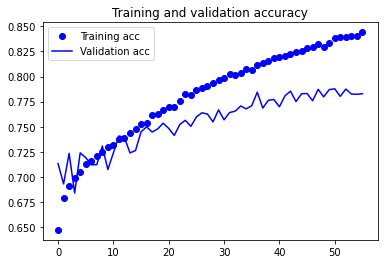

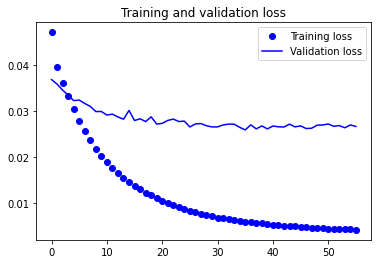

In [203]:
hist_emb3_bidir_aug = open('hist_emb3_bidir_aug.json').read()
hist_emb3_bidir_aug = eval(hist_emb3_bidir_aug)
hist_plot(hist_emb3_bidir_aug)

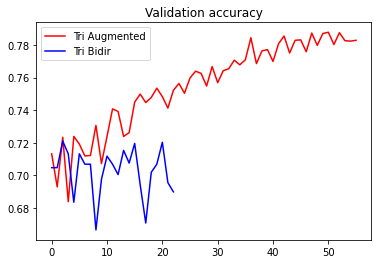

In [204]:
acc_comparison(hist_emb3_bidir_aug, hist_emb3_bidir, 'Tri Augmented', 'Tri Bidir')

Reaching the best value of accuracy for my experiment.

In [167]:
print('The best value of the accuracy is {}%'.format(round(max(hist_emb3_bidir_aug['acc'])*100,2)))

The best value of the accuracy is 84.41%


In [203]:
model_emb3_bidir_aug = load_model('model_emb3_bidir_aug.h5')
model_emb3_bidir_aug.load_weights("model_emb3_bidir_aug_params.h5")

red, R,G,B: 0.9811773 0.06457707 0.15176427


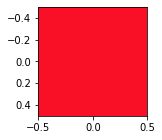

blue, R,G,B: 0.06794223 0.19151956 0.7426721


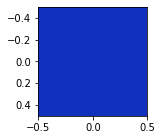

green, R,G,B: 0.16970521 0.8152188 0.26846516


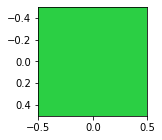

In [124]:
predict_n_emb(3, 'red', 19644, 30, model_emb3_bidir_aug)
predict_n_emb(3, 'blue', 19644, 30, model_emb3_bidir_aug)
predict_n_emb(3, 'green', 19644, 30, model_emb3_bidir_aug)


forest, R,G,B: 0.16083166 0.35939273 0.24559149


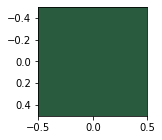

poo, R,G,B: 0.6515248 0.5712687 0.08123383


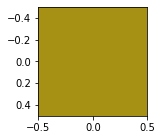

hello kitty, R,G,B: 0.8851818 0.7395592 0.7803867


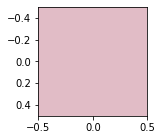

tandori spice, R,G,B: 0.72108066 0.48979092 0.34714007


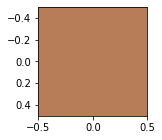

In [85]:
predict_n_emb(3, 'forest', 19644, 30, model_emb3_bidir_aug)
predict_n_emb(3, 'poo', 19644, 30, model_emb3_bidir_aug)
predict_n_emb(3, 'hello kitty', 19644, 30, model_emb3_bidir_aug)
predict_n_emb(3, 'tandori spice', 19644, 30, model_emb3_bidir_aug)

yellow red, R,G,B: 0.93355393 0.5332791 0.13352716


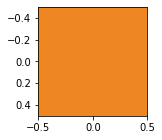

blue red, R,G,B: 0.4940268 0.22243878 0.38835147


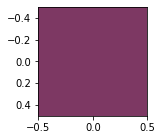

blue green, R,G,B: 0.21037933 0.5685106 0.51409525


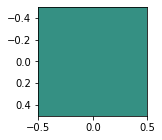

In [216]:
predict_n_emb(3, 'yellow red', 19618, 30, model_emb3)
predict_n_emb(3, 'blue red', 19618, 30, model_emb3)
predict_n_emb(3, 'blue green', 19618, 30, model_emb3)


red army, R,G,B: 0.6569305 0.25151736 0.29181758


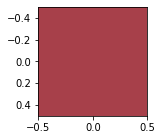

In [219]:
predict_n_emb(3, 'red army', 19618, 30, model_emb3)


Here I tried a different strategy using the google pretrained word2vec. Word vectors can be downloaded at this link: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [223]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary = True)
(total_tokens, dim) = word2vec.vectors.shape
(total_tokens, dim)

(3000000, 300)

The input is made by a fixed dimension tensor $6 \times 300$. We set that each color name has 6 words as maximum value, we raplace words that don't exist in the embedding matrix with a general mean.

In [224]:
avg_vec = np.mean(word2vec.vectors, axis = 0)
empty_vec = np.zeros(dim)
max_tokens = max([len(name.split()) for name in data_aug['name']])

In [225]:
def preproc_word2vec(df):    
    
    X_train = []

    for name in df['name']:
        tokens = name.split()
        X = []
        i = 0

        for token in tokens:
            if token in word2vec:
                X.append(word2vec[token])
            else:
                X.append(avg_vec)
            i += 1

        while i < max_tokens:
            X.append(empty_vec)
            i += 1

        X_train.append(np.array(X))
    return np.array(X_train)


In [226]:
pre_trained = preproc_word2vec(data_aug)
pre_trained.shape

(38538, 6, 300)

We train a simple convolutional architecture.

In [51]:
def model_CNN(max_tokens, dim):
    
    model = Sequential()
    model.add(Conv1D(128, 1, input_shape = (max_tokens, dim), activation = "tanh"))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(3))

    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [52]:
from keras.layers import Conv1D, GlobalMaxPooling1D

model_CNN =  model_CNN(max_tokens, dim)
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 128)            38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 387       
Total params: 38,915
Trainable params: 38,915
Non-trainable params: 0
_________________________________________________________________


In [56]:
checkpoint = ModelCheckpoint("model_CNN_params.h5", monitor = "val_loss", verbose = 1, save_best_only = True)
early_stop = EarlyStopping(patience=20)

hist_CNN = model_CNN.fit(pre_trained, normalized_values_aug, epochs = 100, validation_split = 0.1, callbacks = [checkpoint, early_stop])


Epoch 1/100
1080/1084 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.5698
Epoch 00001: val_loss improved from inf to 0.04092, saving model to model_CNN_params.h5
1084/1084 [==============================] - 3s 3ms/step - loss: 0.0619 - acc: 0.5699 - val_loss: 0.0409 - val_acc: 0.6902
Epoch 2/100
1078/1084 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.6488
Epoch 00002: val_loss improved from 0.04092 to 0.03560, saving model to model_CNN_params.h5
1084/1084 [==============================] - 3s 3ms/step - loss: 0.0453 - acc: 0.6489 - val_loss: 0.0356 - val_acc: 0.6930
Epoch 3/100
1077/1084 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.6627- ETA: 0s - loss: 0.0425 - acc: 0.662 - ETA: 0s - loss: 0.0425 - acc: 0.6
Epoch 00003: val_loss improved from 0.03560 to 0.03533, saving model to model_CNN_params.h5
1084/1084 [==============================] - 4s 3ms/step - loss: 0.0425 - acc: 0.6627 - val_loss: 0.0353 - val_acc: 0.7084
Epoc

1073/1084 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.6937- ETA: 1s - l
Epoch 00058: val_loss did not improve from 0.03013
1084/1084 [==============================] - 3s 3ms/step - loss: 0.0336 - acc: 0.6936 - val_loss: 0.0306 - val_acc: 0.7382
Epoch 59/100
1076/1084 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.6992
Epoch 00059: val_loss did not improve from 0.03013
1084/1084 [==============================] - 4s 3ms/step - loss: 0.0337 - acc: 0.6991 - val_loss: 0.0306 - val_acc: 0.7309
Epoch 60/100
1071/1084 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.6979
Epoch 00060: val_loss did not improve from 0.03013
1084/1084 [==============================] - 3s 2ms/step - loss: 0.0336 - acc: 0.6976 - val_loss: 0.0303 - val_acc: 0.7242
Epoch 61/100
1064/1084 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.6950
Epoch 00061: val_loss did not improve from 0.03013
1084/1084 [==============================] - 2s

In [60]:
hist_model_save(model_CNN, hist_CNN)

As we can see it's a step back in term of accuracy

In [206]:
hist_CNN = open('hist_CNN.json').read()
hist_CNN = eval(hist_CNN)
print('The CNN accuracy value is {}'.format(max(hist_CNN['acc'])))

The CNN accuracy value is 0.7014473676681519


But this preprocessing with google pre trained word embeddings is usefull to build a possible reverse, one-to-many, model.

In [227]:
def preproc_color2vec(df):
    
    df = df.reset_index(drop=True)
    X_train = []
    empty_rgb_vec = 3 * [0]
    mask_rgb_vec = 3 * [-1]

    for idx in data_aug.index:
        tokens = df.loc[idx,'name'].split()
        num_tokens = len(tokens)

        X = [df.iloc[idx,1:4].values.tolist()]
        i = 1
        while i < num_tokens:
            X.append(empty_rgb_vec)
            i += 1

        while i < max_tokens:
            X.append(mask_rgb_vec)
            i += 1

        X_train.append(np.array(X))
    return np.array(X_train)

I built a model that takes as input a tensor with fixed dimensions $6 \times 3$. The first vector is the color in [r,g,b], the information of the number of words is passed by zeros vectors, the remaining vectors are filled with -1 as to use in the model a masking layer. 

For example, the color "a brand new day", that has values [255, 170, 187], is encoded with the tensor:

In [228]:
rgbs = preproc_color2vec(data_aug)
rgbs.shape, rgbs[0]

((38538, 6, 3),
 array([[255, 170, 187],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [ -1,  -1,  -1],
        [ -1,  -1,  -1]]))

The target will be the $6 \times 300$ tensors we used as training set in the previous CNN model, so the last layer of my model will apply the same Dense layer (same weights) to the LSTMs outputs for one time step at a time. It can be done using a  TimeDistributed Layer. 

In [229]:
from keras.layers import Dense, Masking, TimeDistributed

def color2vec():
    model = Sequential()
    model.add(Masking(mask_value = -1, input_shape = (max_tokens, 3)))
    model.add(LSTM(256, return_sequences = True))
    model.add(TimeDistributed(Dense(dim)))

    model.compile(optimizer='adam', loss='mse', metrics=['acc'])
    return model

In [73]:
model_color2words = color2vec()
model_color2words.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 6, 3)              0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 6, 256)            266240    
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 300)            77100     
Total params: 343,340
Trainable params: 343,340
Non-trainable params: 0
_________________________________________________________________


In [172]:
checkpoint = ModelCheckpoint("color2words_params.h5", monitor = "val_loss", verbose = 1, save_best_only = True)
early_stop = EarlyStopping(patience=20)

hist_color2words = model_color2words.fit(rgbs, pre_trained, epochs = 100, validation_split = 0.1, callbacks = [checkpoint, early_stop])
model_color2words.load_weights("color2words_params.h5")


Epoch 1/100
1082/1084 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.0199
Epoch 00001: val_loss improved from inf to 0.00706, saving model to color2words_params.h5
1084/1084 [==============================] - 30s 27ms/step - loss: 0.0072 - acc: 0.0198 - val_loss: 0.0071 - val_acc: 0.0196
Epoch 2/100
1084/1084 [==============================] - ETA: 0s - loss: 0.0071 - acc: 0.0206
Epoch 00002: val_loss improved from 0.00706 to 0.00705, saving model to color2words_params.h5
1084/1084 [==============================] - 29s 27ms/step - loss: 0.0071 - acc: 0.0206 - val_loss: 0.0071 - val_acc: 0.0164
Epoch 3/100
1083/1084 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.0196
Epoch 00003: val_loss did not improve from 0.00705
1084/1084 [==============================] - 28s 26ms/step - loss: 0.0071 - acc: 0.0196 - val_loss: 0.0071 - val_acc: 0.0212
Epoch 4/100
1083/1084 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.0191
Epoch 00004: v

The model seems very poor in terms of validation accuracy, but we can see that postproccesing the outputs we can obtain some good and interesting predictions.

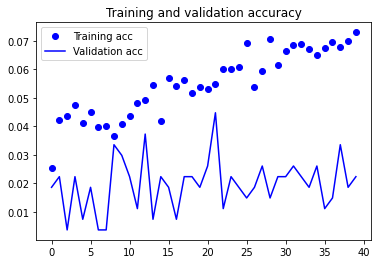

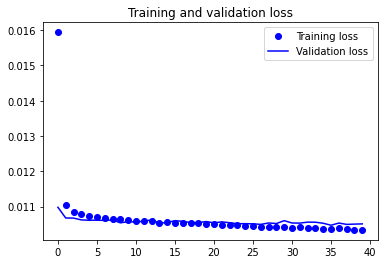

In [207]:
model_color2words = load_model('model_color2words.h5')
hist_color2words = open('hist_color2words.json').read()
hist_color2words = eval(hist_color2words)
hist_plot(hist_color2words)

The way I generate words is the following:

- For each output $w_i \in R^{300}$, $i = (1, \;... \;,6)$, I evaluate the most similar vectors in my embedded pretrained corpus. So, for each of the $3*10^6$ vectors in word2vec I evaluate $cos(\widehat{w_i,v}) = \frac{w_i v^T}{||v||_2 ||w_i||_2}$
- I sorted all the obtained cosines, taking the first 10 (it can be change with the parameter neighbors).
- I evaluate the probability $p_i$ of every word with a Softmax: the output words can be choosen in different ways. Here I just took the most possible.

In [230]:
def magnitude():
    mags = []
    for i in range(word2vec.vectors.shape[0]):
        mags.append(np.sqrt(np.dot(word2vec.vectors[i], word2vec.vectors[i])))
    return np.array(mags)

def rgb_tensor(r, g, b, n_words, max_tokens):
    tensor = np.zeros(shape=(1,max_tokens,3))
    tensor[0][0] = np.array([r,g,b])
    tensor[0][n_words:] = np.array([-1,-1,-1]) 
    return tensor
    
def names_generator(tensor, mags, max_tokens, neighbors=10):    
    #model prediction
    word_vecs = model_color2words.predict(tensor)[0]
    color_name = []
    #number words in the color name
    for word in range(max_tokens):
        #single word in color name
        word_vec = word_vecs[word]
        #module of the word
        word_mag = np.sqrt(np.dot(word_vec, word_vec))
        #projection of each word of the dict with the word of color name
        dotted = np.dot(word_vec, word2vec.vectors.T)
        #cosine of each word
        cosine = dotted / (word_mag * mags)
        keeps = []
        #cosine sorted by magnitude
        for idx in cosine.argsort()[-neighbors:][::-1]:
            #print(word2vec.index2word[idx])
            keeps.append(idx)
        #Soft Max to choose a word
        exp = np.exp(cosine[keeps])
        probs = exp / exp.sum()
        idx = keeps[np.argmax(probs)]
        color_word = word2vec.index2word[idx]
        color_name.append(color_word)
    plot_rgb([int(x) for x in tens[0][0]])    
    return color_name[-1]

As we can see it works with many colors:

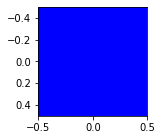

'blue'

In [145]:
mags = magnitude()
tens = rgb_tensor(0, 0, 255, 2, 4)
names_generator(tens, mags, 4, neighbors=10)

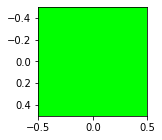

'green'

In [146]:
tens = rgb_tensor(0, 255, 0, 2, 4)
names_generator(tens, mags, 4, neighbors=10)

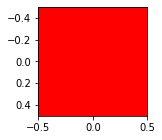

'red'

In [147]:
tens = rgb_tensor(255, 0, 0, 2, 4)
names_generator(tens, mags, 4, neighbors=10)

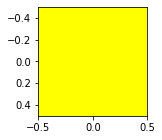

'yellow'

In [178]:
tens = rgb_tensor(255, 255, 0, 2, 4)
names_generator(tens, mags, 4, neighbors=10)

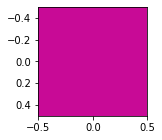

'purple'

In [148]:
tens = rgb_tensor(200, 10, 150, 2, 4)
names_generator(tens, mags, 4, neighbors=10)

Maybe just taking the first sorted word is too limiting. For example this shade of blue is still blue but relaxing a bit the algorithm, taking the first five for example, we will obtain wonderful names like: 'Fisherman_drowns' or 'dolphins_frolicking'. 

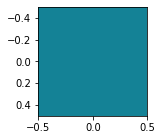

'blue'

In [149]:
tens = rgb_tensor(20, 130, 150, 2, 4)
names_generator(tens, mags, 4, neighbors=10)

In [136]:
def names_generator_relaxed(tensor, mags, max_tokens, number_colors, neighbors=10):    
    #model prediction
    word_vecs = model_color2words.predict(tensor)[0]
    color_name = []
    #number words in the color name
    for word in range(max_tokens):
        #single word in color name
        word_vec = word_vecs[word]
        #module of the word
        word_mag = np.sqrt(np.dot(word_vec, word_vec))
        #projection of each word of the dict with the word of color name
        dotted = np.dot(word_vec, word2vec.vectors.T)
        #cosine of each word
        cosine = dotted / (word_mag * mags)
        keeps = []
        #cosine sorted by magnitude
        for idx in cosine.argsort()[-neighbors:][::-1]:
            #print(word2vec.index2word[idx])
            keeps.append(idx)
        color_list = []    
        for idx in keeps[0:number_colors]:  
            color_list.append(word2vec.index2word[idx])
        color_name.append(color_list)
    plot_rgb([int(x) for x in tens[0][0]])    
    return color_name[-1]

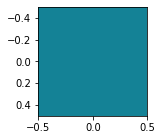

['blue',
 'Fisherman_drowns',
 'rafting_Riggins',
 'dolphins_frolicking',
 'gently_lapping']

In [139]:
tens = rgb_tensor(20, 130, 150, 2, 4)
names_generator_relaxed(tens, mags, 4, 5, neighbors=10)

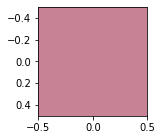

['lavender_flowers',
 'peachy_pink',
 'mauve_pink',
 'dusky_pink',
 'purple_petunias']

In [174]:
tens = rgb_tensor(200, 130, 150, 2, 4)
names_generator_relaxed(tens, mags, 4, 5, neighbors=10)

And finally the tipical color of a mushy broccoli.

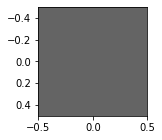

['gray', 'brown', 'mushy_broccoli', 'blue', 'orangey_brown']

In [182]:
tens = rgb_tensor(100, 100, 100, 2, 4)
names_generator_relaxed(tens, mags, 4, 5, neighbors=10)

To conclude we can see that the trigram model learnt something similar but more light.

dolphins frolicking, R,G,B: 0.7614254 0.811651 0.70972705


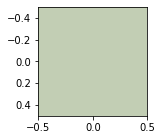

In [188]:
predict_n_emb(3, 'dolphins frolicking', 19644, 30, model_emb3_bidir_aug)

mushy broccoli, R,G,B: 0.800483 0.68081623 0.52457374


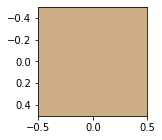

In [189]:
predict_n_emb(3, 'mushy broccoli', 19644, 30, model_emb3_bidir_aug)